# ***Google Drive***

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive/')

sys.path.append('/content/gdrive/MyDrive/NeuralNetwork')
!cd gdrive/MyDrive/NeuralNetwork


Mounted at /content/gdrive/


# ***Import***

In [2]:
import time
import os
import random
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim
import torch.backends.cudnn as cudnn
from torch import autograd
from torch.autograd.function import Function
from torch.autograd import Variable


import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from torchvision import models
from torchsummary import summary


import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import numbers
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

print("Import done.")

Import done.


---
---

# ***The following cells contains the different modules used in our project. They have to be executed once before starting the demo.***




 ---
 ---

# ***Globl***

In [ ]:
class Globl():
    def __init__(self):
        
        self.config = {
            'image_size': 256,
            'batch_size' :64,
            'tot_epochs' : 30,
            'device' : None,
            'save_model_path': '/content/gdrive/MyDrive/NeuralNetwork/best_model',
            'save_model_name': 'model_to_save.pth',
            'lr' : 0.01,
            'lambda' : 0.01,
            'alpha': 0.5,
            'path_dataset': "/content/gdrive/MyDrive/dataset_BN",
            #'path_dataset': '/content/gdrive/MyDrive/DATABASE/archive/data', 
            'pretrain_path': '/content/gdrive/MyDrive/NeuralNetwork/best_model/modello_finale_ok.pth',
            'size_of_crop': 200,
            'pretrain_msceleb': False,
            'mode': "DACL"
        }


globl = Globl().config

torch.manual_seed(1810169 ^ 1801667)
np.random.seed(1810169 ^ 1801667)
random.seed(1810169 ^ 1801667)

if torch.cuda.is_available():
        device = torch.device('cuda:0')
        cudnn.benchmark = True
        print("device: GPU")
        print(torch.cuda.get_device_name(0)) 
else:
        device = torch.device('cpu')
        print("device: CPU")

globl['device'] = device




device: GPU
Tesla K80


# ***Measures***



In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target):
    with torch.no_grad():
        batch_size = target.size(0)
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(target)
        acc = correct.float().sum().mul_(1.0 / batch_size)
    return acc, pred


class RandomFiveCrop(object):

    def __init__(self, size):
        self.size = size
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
            self.size = size

    def __call__(self, img):
        return F.five_crop(img, self.size)[random.randint(0, 4)]

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)

# ***DACLnet***


In [ ]:
class DACLnet(nn.Module):

    def __init__(self):
        super(DACLnet, self).__init__()

        self.dim_input = 64 
        self.conv1 = nn.Conv2d(3, self.dim_input, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(self.dim_input)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ######
        self.layer1 = self.blocks_generator(dim_output= 64)
        ######
        self.layer2 = self.blocks_generator(dim_output= 128, stride= 2)
        ######
        self.layer3 = self.blocks_generator(dim_output= 256, stride= 2)
        ######
        self.layer4 = self.blocks_generator(dim_output= 512, stride= 2)

      
        ### CE-UNIT                   
        self.attention = nn.Sequential(             
            nn.Linear(512*7*7, 3584),
            nn.BatchNorm1d(512*7),
            nn.ReLU(inplace=True),

            nn.Linear(512*7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),              
        )
        ### attention-heads
        self.attention_heads = nn.Linear(64, 2 * 512)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        if (globl['pretrain_msceleb']):
          print("mscleb")
          self.fc = nn.Linear(512, 1000)
        else:
          self.fc = nn.Linear(512, 7)
        

    

    def blocks_generator(self, dim_output, stride = 1, blocks = 2):
      downsample = None
      if stride != 1 or self.dim_input != dim_output:
            downsample = nn.Sequential(
                nn.Conv2d(self.dim_input, dim_output, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(dim_output),
            )

      layers = []
      layers.append(BasicBlock(self.dim_input, dim_output, stride, downsample))
      self.dim_input = dim_output
      
      layers.append(BasicBlock(self.dim_input, dim_output, stride = 1))
      

      return nn.Sequential(*layers)



    def forward(self, x):
      
        x = self.conv1(x)          
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        
        x_flat = torch.flatten(x, 1)
        E = self.attention(x_flat)  
        A = self.attention_heads(E).reshape(-1, 512, 2).softmax(dim=-1)[:, :, 1]
        
        x = self.avgpool(x)         
        feature = torch.flatten(x, 1)     
        out = self.fc(feature)

        return feature, out, A




def resnet18():
    model = DACLnet()
    return model



class BasicBlock(nn.Module):

    def __init__(self, dim_input, dim_output, stride=1, 
                 downsample = None, kernel_size=3, padding = 1):
        super(BasicBlock, self).__init__()
       
    

        self.conv1 = nn.Conv2d(dim_input, dim_output, kernel_size=3, stride=stride, padding=1, groups=1, bias=False, dilation=1)
        self.bn1 = nn.BatchNorm2d(dim_output)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(dim_output, dim_output, kernel_size=3, stride=1,padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(dim_output)
        self.downsample = downsample
        self.stride = stride
        

    def forward(self, x):

        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ***SparseCenterLoss***

In [ ]:

class SparseCenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(SparseCenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.FloatTensor(num_classes, feat_dim))
        self.sparse_centerloss = SparseCenterLossFunction.apply
        self.feat_dim = feat_dim
        self.size_average = size_average
        self.reset_params()

    def reset_params(self):
        nn.init.kaiming_normal_(self.centers.data.t())

    def forward(self, feat, A, label):
        batch_size = feat.size(0)
        feat = feat.view(batch_size, -1)
        
        if feat.size(1) != self.feat_dim:
            raise ValueError("Center's dim: {0} should be equal to input feature's \
                            dim: {1}".format(self.feat_dim, feat.size(1)))
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.sparse_centerloss(feat, A, label, self.centers, batch_size_tensor)
        return loss
        

class SparseCenterLossFunction(Function):
    @staticmethod
    def forward(ctx, feature, A, label, centers, batch_size):
        ctx.save_for_backward(feature, A, label, centers, batch_size)
        centers_batch = centers.index_select(0, label.long())
        return (A * (feature - centers_batch).pow(2)).sum() / 2.0 / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        
        # A:([batch_size, 512])
        # feature:([batch_size, 512])
        # centers: ([7, 512])
        # label: ([batch_size])
        feature, A, label, centers, batch_size = ctx.saved_tensors
    
        # centers_batch ([batch_size, 512])
        centers_batch = centers.index_select(0, label.long())
        diff = feature - centers_batch
        
        
        # counts: ([7])
        counts = centers.new_ones(centers.size(0))
        # ones: ([batch_size])
        ones = centers.new_ones(label.size(0))
        # grad_centers: ([7, 512])
        grad_centers = centers.new_zeros(centers.size())
      
        grad_A = diff.pow(2) / 2.0 / batch_size

        # counts: ([7]) 
        counts.scatter_add_(0, label.long(), ones)
        # indicies: ([batch_size, 512])
        indicies = label.unsqueeze(1).expand(feature.size()).long()

        grad_centers.scatter_add_(0, indicies, - A * diff)
        grad_centers = grad_centers / counts.view(-1, 1)
        return grad_output * A * diff / batch_size, grad_output * grad_A, None, grad_centers, None

# ***Train***

In [ ]:
def train(train_loader, model, epoch, optimizer, criterion, mode="DACL"):
    globl = Globl().config
    acc_tot = 0
    loss_tot = 0

    losses = {
        'softmax': AverageMeter(),
        'center': AverageMeter(),
        'total': AverageMeter()
    }
    accs = AverageMeter()
    model.train()
   

    with tqdm(total=int(len(train_loader.dataset) / globl['batch_size'])) as training_bar:
        for i, (images, target) in enumerate(train_loader):

            images = images.cuda()
            target = target.cuda()
            # compute output
            feature, out, A = model(images)

            if(mode == "center"): 
              A = torch.ones_like(A)

            ### LOSSES
            l_softmax = criterion['softmax'](out,target)
            if (mode == "softmax"):
              l_center = 0
            else:
              l_center =  criterion['center'](feature, A, target)
            l_total = l_softmax + globl['lambda'] * l_center
            
            ### ACCURACY
            acc, pred = accuracy(out, target)


            losses['softmax'].update(l_softmax.item(), images.size(0))
            if (mode != "softmax"):
              losses['center'].update(l_center.item(), images.size(0))
            losses['total'].update(l_total.item(), images.size(0))
            accs.update(acc.item(), images.size(0))
      
            optimizer['softmax'].zero_grad()
            if (mode != "softmax"):
              optimizer['center'].zero_grad()
            l_total.backward()   
            optimizer['softmax'].step()
            if (mode != "softmax"):
              optimizer['center'].step()


            training_bar.set_description(f'TRAINING [{epoch+1:03d}/{globl["tot_epochs"]}]')
            if (mode != "softmax"):
              training_bar.set_postfix({'L_tot':losses["total"].avg,
                                'L_soft': losses["softmax"].avg,
                                'L_center': losses["center"].avg,
                                'acc': accs.avg})
            else:
              training_bar.set_postfix({'L_tot':losses["total"].avg,
                                'acc': accs.avg})
           
            training_bar.update(1)
           
           
            
         
    return losses["total"].avg, accs.avg

# ***Evaluation***

In [ ]:
def evaluation(valid_loader, model, epoch, criterion, mode="DACL"):
    globl = Globl().config
    acc_tot = 0
    loss_tot = 0
  
    model.eval()
    losses = {
        'softmax': AverageMeter(),
        'center': AverageMeter(),
        'total': AverageMeter()
    }
    accs = AverageMeter()
    y_pred, y_true= [], []
   
    with tqdm(total=int(len(valid_loader.dataset) / globl['batch_size'])) as evaluation_bar:
        with torch.no_grad():
            for i, (images, target) in enumerate(valid_loader):

                images = images.cuda()
                target = target.cuda()
                # compute output
                feature, out, A = model(images)
              
                if (mode == "center"):
                  A = torch.ones_like(A)

                #LOSS-----------------------------------
                l_softmax = criterion['softmax'](out,target)
                if (mode == "softmax"):
                  l_center = 0
                else:
                  l_center =  criterion['center'](feature, A, target)

                l_total = l_softmax + globl['lambda'] * l_center

                #ACCURACY----------------------------------------
                acc, pred = accuracy(out, target)
        
          
                losses['softmax'].update(l_softmax.item(), images.size(0))
                if (mode != "softmax"):
                  losses['center'].update(l_center.item(), images.size(0))
                losses['total'].update(l_total.item(), images.size(0))
                accs.update(acc.item(), images.size(0))


                evaluation_bar.set_description(f'EVALUATION [{epoch+1:03d}/{globl["tot_epochs"]}]')
                evaluation_bar.set_postfix({'val_acc':accs.avg,
                                'val_los': losses["total"].avg})
                evaluation_bar.update(1)
                
    return losses["total"].avg, accs.avg


# ***Validate***

In [ ]:

def validate(valid_loader, model, criterion, mode="DACL"):
    globl = Globl().config
    acc_tot = 0
    loss_tot = 0
  
    model.eval()
    losses = {
        'softmax': AverageMeter(),
        'center': AverageMeter(),
        'total': AverageMeter()
    }
    accs = AverageMeter()
    y_pred, y_true= [], []
    print("Mode: ", mode)
    with tqdm(total=int(len(valid_loader.dataset) / globl['batch_size'])) as validation_bar:
        with torch.no_grad():
            for i, (images, target) in enumerate(valid_loader):

                images = images.cuda()
                target = target.cuda()
                # compute output
                feature, out, A = model(images)
                

                #CONFUSION MATRIX DATA------------------
                output = (torch.max(out, 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction
                y_true.extend(target.cpu().numpy()) # Save Truth
              

                if (mode == "center"):
                  A = torch.ones_like(A)

                #LOSS-----------------------------------
                l_softmax = criterion['softmax'](out,target)
                if (mode == "softmax"):
                  l_center = 0
                else:
                  l_center =  criterion['center'](feature, A, target)

                l_total = l_softmax + globl['lambda'] * l_center

                #ACCURACY----------------------------------------
                acc, pred = accuracy(out, target)
        
          
                losses['softmax'].update(l_softmax.item(), images.size(0))
                if (mode != "softmax"):
                  losses['center'].update(l_center.item(), images.size(0))
                losses['total'].update(l_total.item(), images.size(0))
                accs.update(acc.item(), images.size(0))

           
                validation_bar.set_postfix({'val_acc':accs.avg,
                                            'val_los': losses["total"].avg})
                validation_bar.update(1)
                
    return y_pred, y_true


# ***Save***




In [ ]:
def save_model(model_state_dict, name = globl['save_model_name'], epoch= globl['tot_epochs'], path= globl['save_model_path'], 
              train_acc_history=[], train_loss_history=[], val_acc_history=[], val_loss_history=[],):

  torch.save({'epoch': epoch,
              'name': name,
              'model_state_dict': model.state_dict(),
              'train_acc_history': train_acc_history,
              'train_loss_history': train_loss_history,
              'val_acc_history': val_acc_history,
              'val_loss_history': val_loss_history
              },os.path.join(path, name),)

# ***Confusion Matrix***

In [ ]:
@torch.no_grad()
def validate_confusionMatrix(model,valid_loader, criterion, mode="DACL"):
    globl = Globl().config
    acc_tot = 0
    loss_tot = 0
  
    model.eval()
    losses = {
        'softmax': AverageMeter(),
        'center': AverageMeter(),
        'total': AverageMeter()
    }
    accs = AverageMeter()
    y_pred, y_true= [], []
    print("Mode: ", mode)
    with tqdm(total=int(len(valid_loader.dataset) / globl['batch_size'])) as validation_bar:
        with torch.no_grad():
            for i, (images, target) in enumerate(valid_loader):

                images = images.cuda()
                target = target.cuda()
                # compute output
                feature, out, A = model(images)
                

                #CONFUSION MATRIX DATA------------------
                output = (torch.max(out, 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction
                y_true.extend(target.cpu().numpy()) # Save Truth
              

                if (mode == "center"):
                  A = torch.ones_like(A)

                #LOSS-----------------------------------
                l_softmax = criterion['softmax'](out,target)
                if (mode == "softmax"):
                  l_center = 0
                else:
                  l_center =  criterion['center'](feature, A, target)

                l_total = l_softmax + globl['lambda'] * l_center

                #ACCURACY----------------------------------------
                acc, pred = accuracy(out, target)
        
          
                losses['softmax'].update(l_softmax.item(), images.size(0))
                if (mode != "softmax"):
                  losses['center'].update(l_center.item(), images.size(0))
                losses['total'].update(l_total.item(), images.size(0))
                accs.update(acc.item(), images.size(0))

           
                validation_bar.set_postfix({'val_acc':accs.avg,
                                            'val_los': losses["total"].avg})
                validation_bar.update(1)

    classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    cf_matrix = confusion_matrix(y_true, y_pred, normalize = 'true')
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    ## print avarage accuracy
    acc_media = 0
    index = 0
    for row in cf_matrix:
      acc_media += row[index]
      index+=1
    print("Avarage accuracy confusion matrix", round(acc_media/7, 2))


    return 

# ***Single Image classification***

In [3]:
import numpy
@torch.no_grad()
def singleImageTest(image_path, model):
  emotions= {0: "Angry", 1: "Disgust", 2: "Fear", 3:"Happy", 4: "Sad", 5 :"Surprise", 6: "Neutral"}
  normalize = transforms.Normalize(mean=[0.5752, 0.4495, 0.4012],std=[0.2086, 0.1911, 0.1827])

  ###TO BE SHOWN
  loader = transforms.Compose([ transforms.Resize((globl['image_size'], globl['image_size'])),transforms.ToTensor()])
  image_show = Image.open(image_path).convert('RGB')
  image_show= loader(image_show).float()
  image_show = Variable(image_show, requires_grad=True)
  image_show = image_show.unsqueeze(0).to(device)


  numpy_arr_show = image_show.cpu().detach().numpy()[0]


  numpy_arr_show = numpy.swapaxes(numpy_arr_show,0,2)
  numpy_arr_show = numpy.swapaxes(numpy_arr_show,0,1)
  plt.figure()
  plt.imshow(numpy_arr_show)
  plt.show()


  ###TO BE USED

  loader = transforms.Compose([ transforms.Resize((globl['image_size'], globl['image_size'])),transforms.ToTensor(), normalize])
  image = Image.open(image_path).convert('RGB')
  image = loader(image).float()
  image = Variable(image, requires_grad=True)
  image = image.unsqueeze(0).to(device)

  
  numpy_arr = image.cpu().detach().numpy()[0]
  numpy_arr = numpy.swapaxes(numpy_arr,0,2)
  numpy_arr = numpy.swapaxes(numpy_arr,0,1)


  model.eval()
  with torch.no_grad():
    feature, out, A = model(image)
    pred = torch.argmax(out, dim=1)
    
  return emotions[pred[0].item()], A[0]






---
---

# ***Starting project demo***


---
---



# ***Loading dataset***

In [ ]:
normalize = transforms.Normalize(mean=[0.5752, 0.4495, 0.4012],std=[0.2086, 0.1911, 0.1827])
# TRAIN SET----------------------------------------------

train_set = datasets.ImageFolder(
    root=os.path.join(globl['path_dataset'], 'train'),
    transform=transforms.Compose([
        transforms.Resize(globl['image_size']),
        RandomFiveCrop(globl['size_of_crop']),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size= globl['batch_size'] 
    , shuffle=True,
    num_workers=2,
    pin_memory=True
)
print("Trainset loaded: ", len(train_set), " images." )


# TEST SET----------------------------------------------

test_set = datasets.ImageFolder(
    root=os.path.join(globl['path_dataset'], 'test'),
    transform=transforms.Compose([
        transforms.Resize(globl['image_size']),
        transforms.CenterCrop(globl['size_of_crop']),
        transforms.ToTensor(),
        normalize,
    ])
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size= globl['batch_size'], shuffle=True,
    num_workers=2,
    pin_memory=True
)
print("Testset loaded: ", len(test_set), " images." )

#/content/gdrive/MyDrive/DATABASE/archive/data #/content/gdrive/MyDrive/dataset_BN
val_set = datasets.ImageFolder(
    root=os.path.join(globl['path_dataset'], 'val'), 
    transform=transforms.Compose([
        transforms.Resize(globl['image_size']),
        transforms.ToTensor(),
        normalize,
    ])
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size= globl['batch_size'], shuffle=True,
    num_workers=2,
    pin_memory=True
)
print("Valset loaded: ", len(val_set), " images." )

print("Done.")


Trainset loaded:  28709  images.
Testset loaded:  3589  images.
Valset loaded:  3589  images.
Done.


# ***Build Model***

In [ ]:
model = resnet18().to(device)

if(globl['pretrain_msceleb']):
  msceleb_model = torch.load('/content/gdrive/MyDrive/Colab Notebooks/resnet18_msceleb.pth')
  state_dict = msceleb_model['state_dict']
  model.load_state_dict(state_dict, strict=False)
  model.fc = nn.Linear(512, 7).to(device)

print("Model created.")

Model created.


In [ ]:
# OPTIMIZER ----------------------------------------------
criterion = {
    'softmax': nn.CrossEntropyLoss().to(device),
    'center': SparseCenterLoss(7, 512).to(device)
}
optimizer = {
    'softmax': torch.optim.SGD(model.parameters(), globl['lr'],
                                momentum= 0.9,
                                weight_decay=0.0005),
    'center': torch.optim.SGD(criterion['center'].parameters(), globl['alpha'])
}
scheduler = torch.optim.lr_scheduler.StepLR(optimizer['softmax'], step_size=20, gamma=0.1)

# ***Training and Evaluation***

In [ ]:

# TRAIN THE MODEL ----------------------------------------------
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range (0, globl['tot_epochs']):
    train_loss, train_acc = train(train_loader, model, epoch, optimizer, criterion, mode = globl['mode']) 
    val_loss, val_acc = evaluation(test_loader, model, epoch, criterion, mode = globl['mode'])  
    print("")
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step()

print("")
print("Completed.")

  0%|          | 0/448 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
TRAINING [001/30]: : 449it [49:13,  6.58s/it, L_tot=1.85, L_soft=1.82, L_center=3.42, acc=0.255]
EVALUATION [001/30]: : 57it [05:45,  6.07s/it, val_acc=0.327, val_los=1.68]


TRAINING [002/30]: : 449it [03:01,  2.48it/s, L_tot=1.61, L_soft=1.59, L_center=1.66, acc=0.37]
EVALUATION [002/30]: : 57it [00:19,  2.91it/s, val_acc=0.475, val_los=1.42]                      


TRAINING [003/30]: : 449it [03:04,  2.43it/s, L_tot=1.44, L_soft=1.42, L_center=1.52, acc=0.453]
EVALUATION [003/30]: : 57it [00:19,  2.86it/s, val_acc=0.49, val_los=1.38]                      


TRAINING [004/30]: : 449it [03:03,  2.45it/s, L_tot=1.33, L_soft=1.32, L_center=1.41, acc=0.498]
EVALUATION [004/30]: : 57it [00:19,  2.91it/s, val_acc=0.503, val_los=1.33]                      


TRAINING [005/30]: : 449it [03:03,  2.44it/s, L_tot=1.26, L_soft=1.25, L_center=1.33, acc=0.527]
EVALUATION [005/30]: : 57it [00:20,  2.82it/s, val_acc=0.523, val_los=1.25]                      


TRAINING [006/30]: : 449it [03:04,  2.44it/s, L_tot=1.21, L_soft=1.2, L_center=1.22, acc=0.546]
EVALUATION [006/30]: : 57it [00:19,  2.88it/s, val_acc=0.558, val_los=1.17]                      


TRAINING [007/30]: : 449it [03:02,  2.46it/s, L_tot=1.17, L_soft=1.15, L_center=1.18, acc=0.563]
EVALUATION [007/30]: : 57it [00:20,  2.80it/s, val_acc=0.522, val_los=1.23]                      


TRAINING [008/30]: : 449it [03:04,  2.43it/s, L_tot=1.12, L_soft=1.11, L_center=1.14, acc=0.579]
EVALUATION [008/30]: : 57it [00:19,  2.87it/s, val_acc=0.575, val_los=1.14]                      


TRAINING [009/30]: : 449it [03:05,  2.42it/s, L_tot=1.09, L_soft=1.08, L_center=1.1, acc=0.591]
EVALUATION [009/30]: : 57it [00:20,  2.80it/s, val_acc=0.513, val_los=1.27]                      


TRAINING [010/30]: : 449it [03:05,  2.42it/s, L_tot=1.07, L_soft=1.06, L_center=1.07, acc=0.602]
EVALUATION [010/30]: : 57it [00:19,  2.90it/s, val_acc=0.595, val_los=1.09]                      


TRAINING [011/30]: : 449it [03:06,  2.41it/s, L_tot=1.04, L_soft=1.03, L_center=1.05, acc=0.612]
EVALUATION [011/30]: : 57it [00:20,  2.76it/s, val_acc=0.592, val_los=1.1]                      


TRAINING [012/30]: : 449it [03:05,  2.42it/s, L_tot=1.02, L_soft=1.01, L_center=1.04, acc=0.623]
EVALUATION [012/30]: : 57it [00:19,  2.88it/s, val_acc=0.613, val_los=1.06]                      


TRAINING [013/30]: : 449it [03:09,  2.37it/s, L_tot=0.989, L_soft=0.979, L_center=1.02, acc=0.637]
EVALUATION [013/30]: : 57it [00:20,  2.82it/s, val_acc=0.603, val_los=1.08]                      


TRAINING [014/30]: : 449it [03:07,  2.40it/s, L_tot=0.971, L_soft=0.961, L_center=0.999, acc=0.64]
EVALUATION [014/30]: : 57it [00:20,  2.78it/s, val_acc=0.577, val_los=1.13]                      


TRAINING [015/30]: : 449it [03:09,  2.37it/s, L_tot=0.954, L_soft=0.944, L_center=0.972, acc=0.642]
EVALUATION [015/30]: : 57it [00:20,  2.83it/s, val_acc=0.604, val_los=1.08]                      


TRAINING [016/30]: : 449it [03:09,  2.37it/s, L_tot=0.928, L_soft=0.918, L_center=0.971, acc=0.656]
EVALUATION [016/30]: : 57it [00:20,  2.72it/s, val_acc=0.612, val_los=1.1]                      


TRAINING [017/30]: : 449it [03:08,  2.38it/s, L_tot=0.911, L_soft=0.902, L_center=0.964, acc=0.662]
EVALUATION [017/30]: : 57it [00:20,  2.83it/s, val_acc=0.597, val_los=1.1]                      


TRAINING [018/30]: : 449it [03:08,  2.39it/s, L_tot=0.89, L_soft=0.88, L_center=0.961, acc=0.671]
EVALUATION [018/30]: : 57it [00:20,  2.82it/s, val_acc=0.619, val_los=1.03]                      


TRAINING [019/30]: : 449it [03:08,  2.38it/s, L_tot=0.876, L_soft=0.867, L_center=0.942, acc=0.674]
EVALUATION [019/30]: : 57it [00:20,  2.78it/s, val_acc=0.592, val_los=1.08]                      


TRAINING [020/30]: : 449it [03:11,  2.34it/s, L_tot=0.861, L_soft=0.852, L_center=0.945, acc=0.682]
EVALUATION [020/30]: : 57it [00:20,  2.73it/s, val_acc=0.635, val_los=1.02]                      


TRAINING [021/30]: : 449it [03:10,  2.36it/s, L_tot=0.726, L_soft=0.716, L_center=1.01, acc=0.737]
EVALUATION [021/30]: : 57it [00:20,  2.73it/s, val_acc=0.67, val_los=0.941]                      


TRAINING [022/30]: : 449it [03:11,  2.35it/s, L_tot=0.677, L_soft=0.666, L_center=1.17, acc=0.757]
EVALUATION [022/30]: : 57it [00:20,  2.78it/s, val_acc=0.67, val_los=0.946]                      


TRAINING [023/30]: : 449it [03:08,  2.38it/s, L_tot=0.642, L_soft=0.63, L_center=1.21, acc=0.771]
EVALUATION [023/30]: : 57it [00:21,  2.71it/s, val_acc=0.669, val_los=0.953]                      


TRAINING [024/30]: : 449it [03:10,  2.36it/s, L_tot=0.615, L_soft=0.602, L_center=1.24, acc=0.783]
EVALUATION [024/30]: : 57it [00:20,  2.79it/s, val_acc=0.666, val_los=0.96]                      


TRAINING [025/30]: : 449it [03:09,  2.36it/s, L_tot=0.596, L_soft=0.584, L_center=1.25, acc=0.789]
EVALUATION [025/30]: : 57it [00:20,  2.77it/s, val_acc=0.668, val_los=0.977]                      


TRAINING [026/30]: : 449it [03:10,  2.36it/s, L_tot=0.569, L_soft=0.557, L_center=1.26, acc=0.801]
EVALUATION [026/30]: : 57it [00:20,  2.76it/s, val_acc=0.67, val_los=0.986]                      


TRAINING [027/30]: : 449it [03:09,  2.37it/s, L_tot=0.548, L_soft=0.536, L_center=1.28, acc=0.809]
EVALUATION [027/30]: : 57it [00:20,  2.82it/s, val_acc=0.669, val_los=0.99]                      


TRAINING [028/30]: : 449it [03:08,  2.38it/s, L_tot=0.529, L_soft=0.516, L_center=1.28, acc=0.818]
EVALUATION [028/30]: : 57it [00:20,  2.82it/s, val_acc=0.665, val_los=1]                      


TRAINING [029/30]: : 449it [03:08,  2.39it/s, L_tot=0.513, L_soft=0.5, L_center=1.29, acc=0.824]
EVALUATION [029/30]: : 57it [00:21,  2.70it/s, val_acc=0.671, val_los=1.02]                      


TRAINING [030/30]: : 449it [03:11,  2.35it/s, L_tot=0.485, L_soft=0.472, L_center=1.3, acc=0.834]
EVALUATION [030/30]: : 57it [00:20,  2.72it/s, val_acc=0.674, val_los=1.02]                      



Completed.


# ***Save option***


In [ ]:
save_model(model.state_dict(), 
            train_acc_history= train_accs, 
            train_loss_history= train_losses, 
            val_acc_history= val_accs, 
            val_loss_history= val_losses )

---
---

# ***Now, it's possible to check the performance and the results of the model***


---
---

# ***Explore results: Plot accuracy, loss and confusion matrix***





> Pretrained model option



In [ ]:
criterion = {
    'softmax': nn.CrossEntropyLoss().to(device),
    'center': SparseCenterLoss(7, 512).to(device)
}
normalize = transforms.Normalize(mean=[0.5752, 0.4495, 0.4012],std=[0.2086, 0.1911, 0.1827])

model = resnet18().to(device)

checkpoint = torch.load(globl['pretrain_path'])

if (globl['pretrain_msceleb']):
  model.fc = nn.Linear(512, 7).to(device)

model.load_state_dict(checkpoint['model_state_dict'])


pretrained_epoch = checkpoint['epoch']
train_accs= checkpoint['train_acc_history']
val_accs= checkpoint['val_acc_history']
train_losses= checkpoint['train_loss_history']
val_losses= checkpoint['val_loss_history']


print("epoch: ", pretrained_epoch)

epoch:  30


> Results plot

Accuracy:


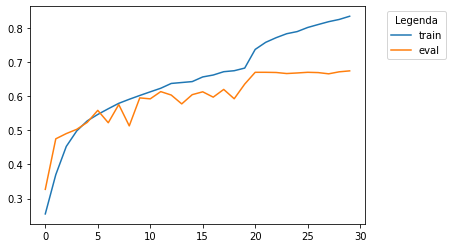

In [ ]:
print("Accuracy:")
p1, =plt.plot(train_accs, label='train')
p2, =plt.plot(val_accs, label='eval')
plt.legend(handles=[p1, p2], title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')

Loss:


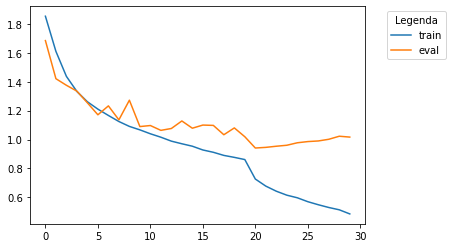

In [ ]:
print("Loss:")
p1, =plt.plot(train_losses, label='train')
p2, =plt.plot(val_losses, label='eval')
plt.legend(handles=[p1, p2], title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')

Mode:  DACL


57it [00:19,  2.88it/s, val_acc=0.649, val_los=1.53]                        


Avarage accuracy confusion matrix 0.61


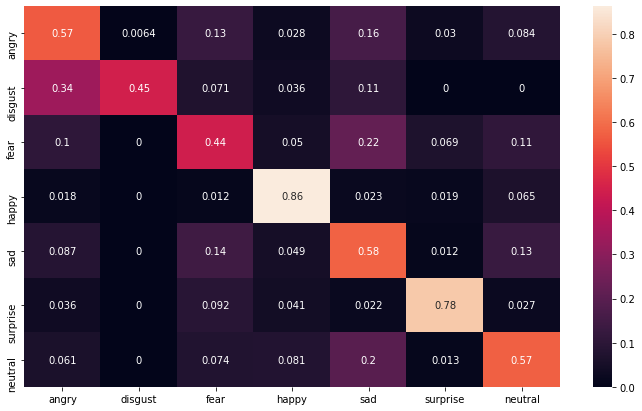

In [ ]:
validate_confusionMatrix(model, val_loader, criterion, mode = globl['mode'])

# ***Attention weight visualization***

>Disgust class

Disgust


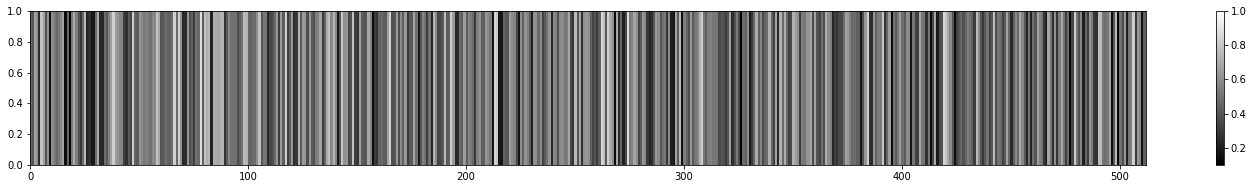

Disgust


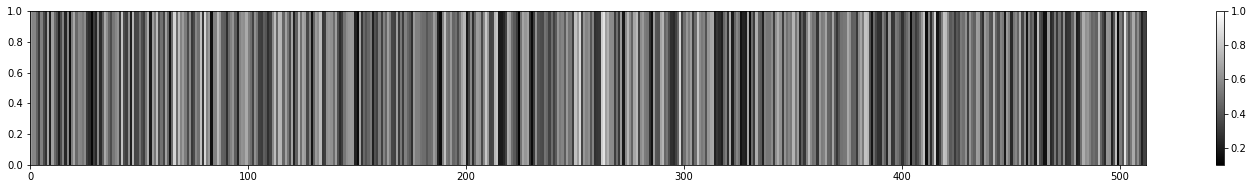

Disgust


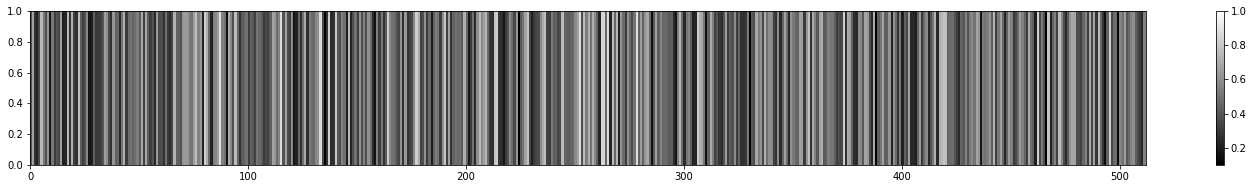

In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/val/1/31368.png", model)
print(risultato)

fig = plt.figure(figsize=(25,13))
att_weights = np.array([(attention).cpu().detach().numpy()])
plt.subplot(4, 1, 2)
mesh=plt.pcolormesh(att_weights, cmap="gray", alpha=1, vmin=0.1, vmax= 1)
plt.colorbar(mesh, orientation='vertical')
plt.show()

risultato, attention= singleImageTest(globl['path_dataset'] +  "/val/1/31828.png", model)
print(risultato)

fig = plt.figure(figsize=(25,13))
att_weights = np.array([(attention).cpu().detach().numpy()])
plt.subplot(4, 1, 2)
mesh=plt.pcolormesh(att_weights, cmap="gray", alpha=1, vmin=0.1, vmax= 1)
plt.colorbar(mesh, orientation='vertical')
plt.show()


risultato, attention= singleImageTest(globl['path_dataset'] +  "/val/1/30428.png", model)
print(risultato)


fig = plt.figure(figsize=(25,13))
att_weights = np.array([(attention).cpu().detach().numpy()])
plt.subplot(4, 1, 2)
mesh=plt.pcolormesh(att_weights, cmap="gray", alpha=1, vmin=0.1, vmax= 1)
plt.colorbar(mesh, orientation='vertical')
plt.show()


>surpraise class

Surprise


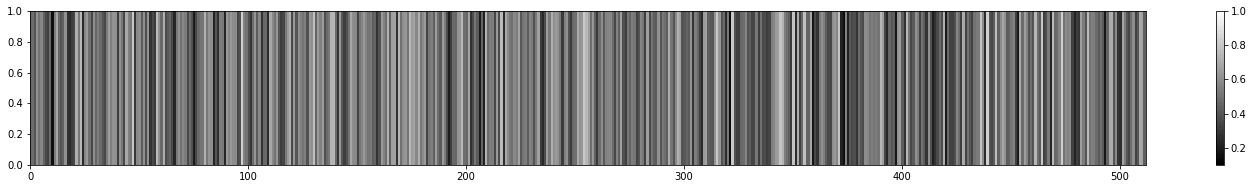

Surprise


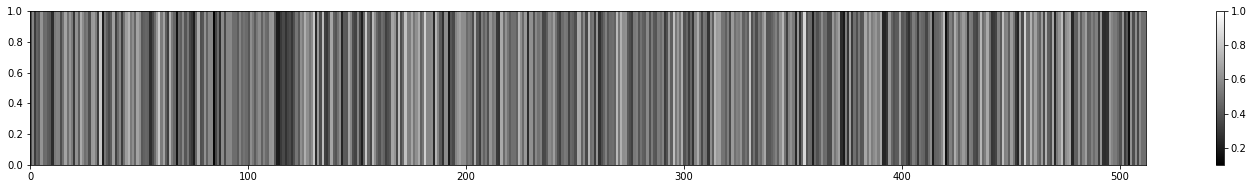

In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/val/5/30005.png", model)
print(risultato)

fig = plt.figure(figsize=(25,13))
att_weights = np.array([(attention).cpu().detach().numpy()])
plt.subplot(4, 1, 2)
mesh=plt.pcolormesh(att_weights, cmap="gray", alpha=1, vmin=0.1, vmax= 1)
plt.colorbar(mesh, orientation='vertical') 
plt.show()

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/5/29110.png", model)
print(risultato)

fig = plt.figure(figsize=(25,13))
att_weights = np.array([(attention).cpu().detach().numpy()])
plt.subplot(4, 1, 2)
mesh=plt.pcolormesh(att_weights, cmap="gray", alpha=1, vmin=0.1, vmax= 1)
plt.colorbar(mesh, orientation='vertical') 
plt.show()



# ***Some examples of correct and incorrect classification***

>Angry

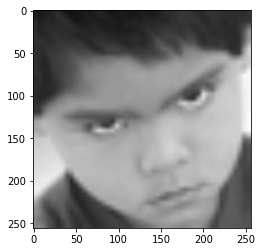

correct: Angry
prediction:  Angry


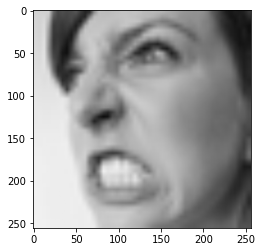

correct: Angry
prediction:  Angry
---------------------------------------------------------------


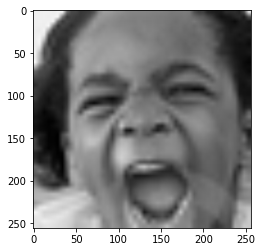

correct: Angry
prediction:  Fear


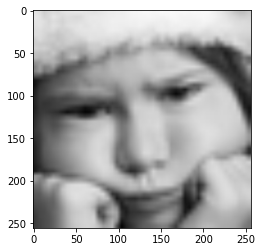

correct: Angry
prediction:  Sad


In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/val/0/32281.png", model)
print("correct: Angry")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/0/32023.png", model)
print("correct: Angry")
print("prediction: ", risultato)

print("---------------------------------------------------------------")

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/0/30745.png", model)
print("correct: Angry")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/0/30933.png", model)
print("correct: Angry")
print("prediction: ", risultato)


>Disgust

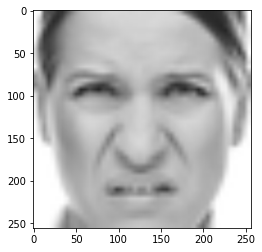

correct: Disgust
prediction:  Disgust


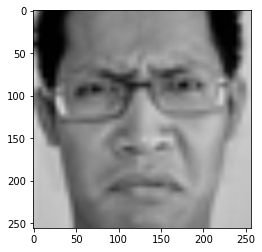

correct: Disgust
prediction:  Angry
---------------------------------------------------------------


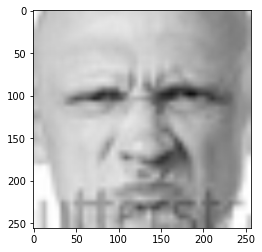

correct: Disgust
prediction:  Angry


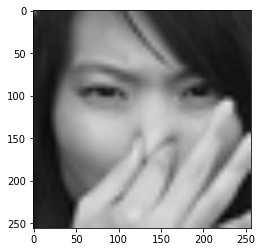

correct: Disgust
prediction:  Fear


In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/val/1/32260.png", model)
print("correct: Disgust")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/1/28987.png", model)
print("correct: Disgust")
print("prediction: ", risultato)

print("---------------------------------------------------------------")

risultato, attention= singleImageTest(globl['path_dataset'] + "/test/1/34958.png", model)
print("correct: Disgust")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/1/29547.png", model)
print("correct: Disgust")
print("prediction: ", risultato)

>Fear

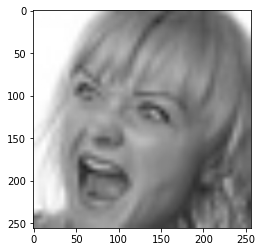

correct: Fear
prediction:  Fear


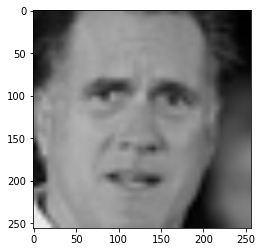

correct: Fear
prediction:  Fear
---------------------------------------------------------------


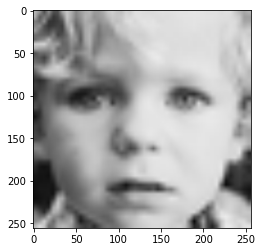

correct: Fear
prediction:  Sad


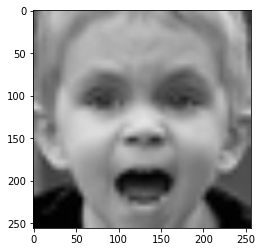

correct: Fear
prediction:  Angry


In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/val/2/32114.png", model)
print("correct: Fear")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/2/31989.png", model)
print("correct: Fear")
print("prediction: ", risultato)

print("---------------------------------------------------------------")

risultato, attention= singleImageTest(globl['path_dataset'] + "/test/2/33111.png", model)
print("correct: Fear")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/test/2/33673.png", model)
print("correct: Fear")
print("prediction: ", risultato)

>Happy

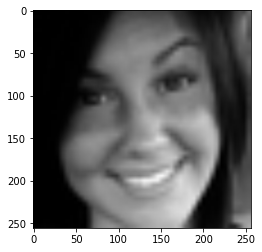

correct: Happy
prediction:  Happy


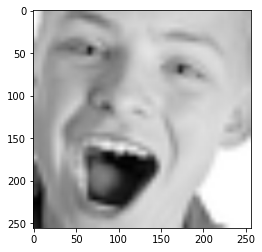

correct: Happy
prediction:  Happy
---------------------------------------------------------------


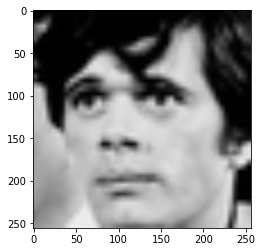

correct: Happy
prediction:  Neutral


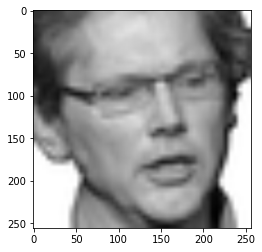

correct: Happy
prediction:  Angry


In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/val/3/32292.png", model)
print("correct: Happy")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/3/32247.png", model)
print("correct: Happy")
print("prediction: ", risultato)

print("---------------------------------------------------------------")

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/3/32066.png", model)
print("correct: Happy")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/3/32051.png", model)
print("correct: Happy")
print("prediction: ", risultato)

>Sad

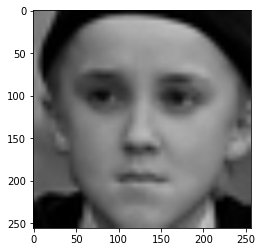

correct: Sad
prediction:  Sad


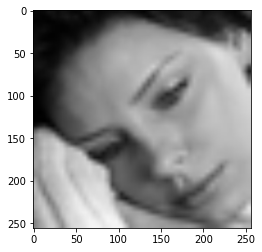

correct: Sad
prediction:  Sad
---------------------------------------------------------------


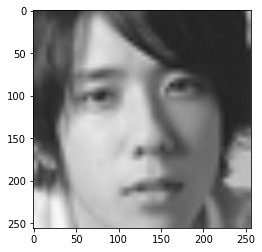

correct: Sad
prediction:  Neutral


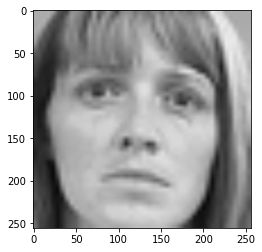

correct: Sad
prediction:  Surprise


In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/val/4/32195.png", model)
print("correct: Sad")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/4/32091.png", model)
print("correct: Sad")
print("prediction: ", risultato)

print("---------------------------------------------------------------")

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/4/32226.png", model)
print("correct: Sad")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/4/32193.png", model)
print("correct: Sad")
print("prediction: ", risultato)

>Surprise

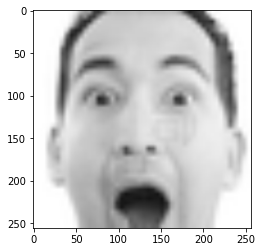

correct: Surprise
prediction:  Surprise


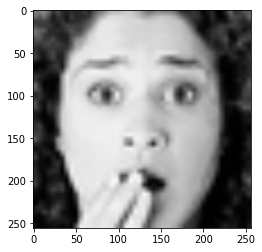

correct: Surprise
prediction:  Surprise
---------------------------------------------------------------


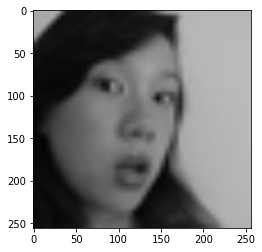

correct: Surprise
prediction:  Fear


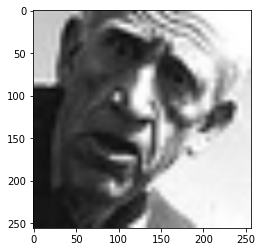

correct: Surprise
prediction:  Fear


In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/test/5/32925.png", model)
print("correct: Surprise")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/5/32266.png", model)
print("correct: Surprise")
print("prediction: ", risultato)

print("---------------------------------------------------------------")

risultato, attention= singleImageTest(globl['path_dataset'] + "/test/5/33272.png", model)
print("correct: Surprise")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/test/5/33800.png", model)
print("correct: Surprise")
print("prediction: ", risultato)

>Neutral

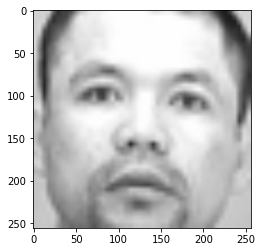

correct: Neutral
prediction:  Neutral


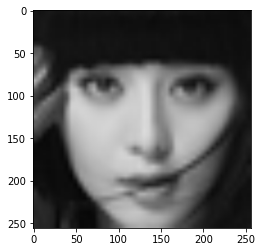

correct: Neutral
prediction:  Neutral
---------------------------------------------------------------


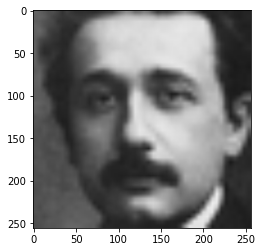

correct: Neutral
prediction:  Sad


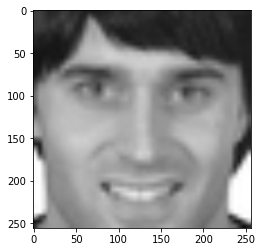

correct: Neutral
prediction:  Happy


In [ ]:
risultato, attention= singleImageTest(globl['path_dataset'] + "/val/6/32081.png", model)
print("correct: Neutral")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/6/32106.png", model)
print("correct: Neutral")
print("prediction: ", risultato)

print("---------------------------------------------------------------")

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/6/32269.png", model)
print("correct: Neutral")
print("prediction: ", risultato)

risultato, attention= singleImageTest(globl['path_dataset'] + "/val/6/32222.png", model)
print("correct: Neutral")
print("prediction: ", risultato)